# 🏭 Predictive Maintenance AI — End‑to‑End Demo

This notebook demonstrates a simple end‑to‑end workflow for predicting manufacturing machine failures.
It includes: data loading, preprocessing, model training, evaluation, feature importance, and model export for a frontend demo.

**Tech:** Python, Pandas, Scikit‑learn, Matplotlib

**Business goal:** Identify machines at risk of failure to reduce unplanned downtime and optimize maintenance schedules.

## 1) Setup & Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib
import os

pd.set_option('display.max_columns', 50)

## 2) Load Data

In [3]:
df = pd.read_csv("predictive_maintenance_data.csv")
df.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure
0,301.52,311.01,1521.15,45.57,90.69,1
1,294.80,304.20,1607.89,45.77,235.60,1
2,303.75,312.36,1323.33,44.50,63.80,0
3,304.70,315.56,1465.76,42.64,208.74,1
4,290.24,300.71,1599.50,42.48,224.21,1


## 3) Exploratory Data Analysis (EDA)

In [4]:
# Basic stats
df.describe()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,299.900622,309.899374,1498.951916,40.296672,124.676466,0.435600
std,4.997264,5.328720,119.945114,6.033532,72.253377,0.495885
min,281.760000,290.450000,1033.460000,17.800000,0.040000,0.000000
25%,296.540000,306.450000,1418.320000,36.157500,61.812500,0.000000
50%,299.980000,309.930000,1496.150000,40.280000,124.450000,0.000000
75%,303.160000,313.400000,1579.492500,44.380000,188.695000,1.000000
max,317.270000,329.200000,1998.150000,59.200000,250.000000,1.000000


In [5]:
# Class balance
class_counts = df['machine_failure'].value_counts().sort_index()
class_counts

machine_failure
0    2822
1    2178
Name: count, dtype: int64

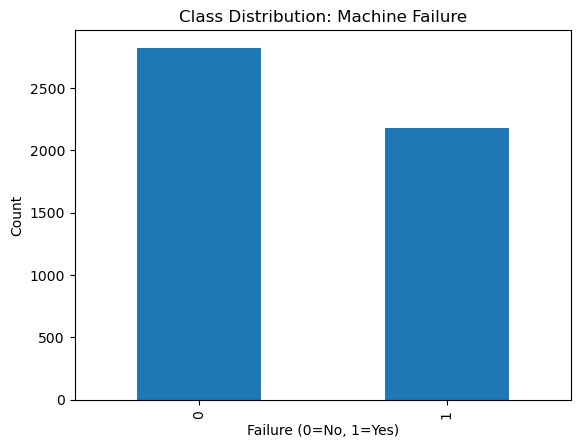

In [6]:
# Plot class distribution (matplotlib only)
plt.figure()
class_counts.plot(kind='bar')
plt.title('Class Distribution: Machine Failure')
plt.xlabel('Failure (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

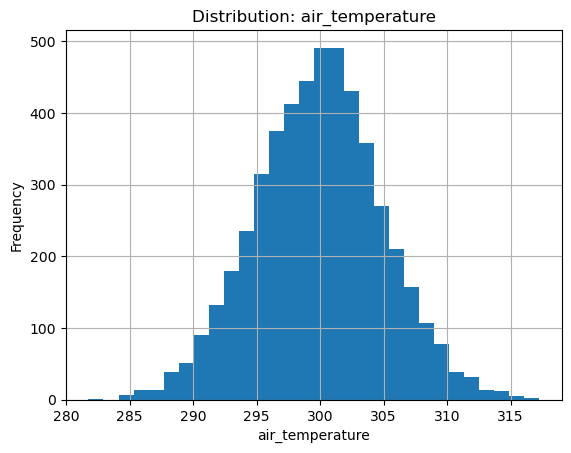

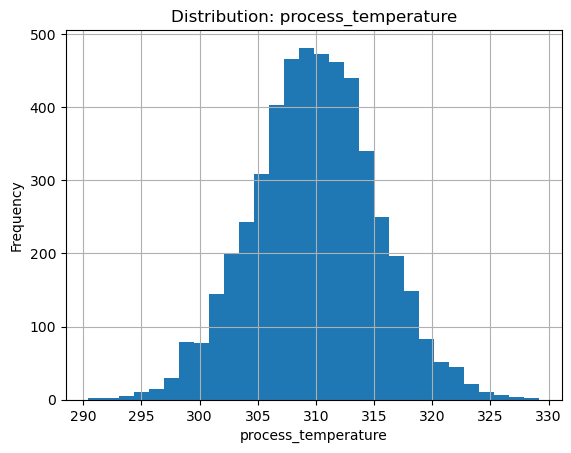

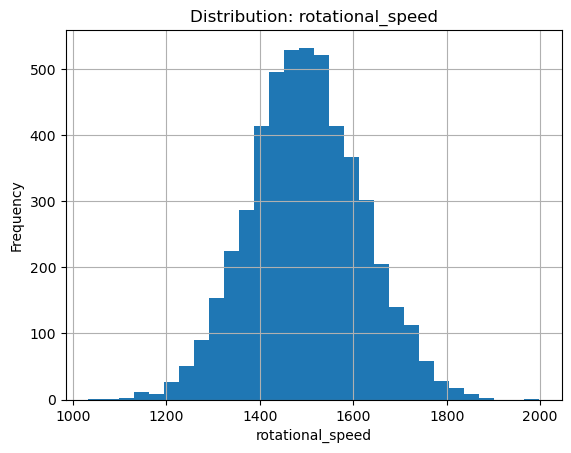

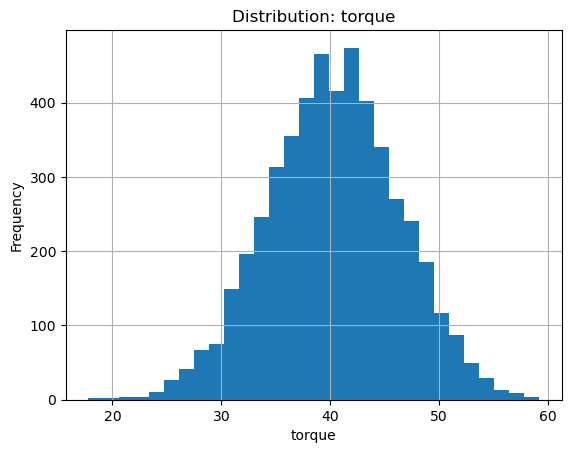

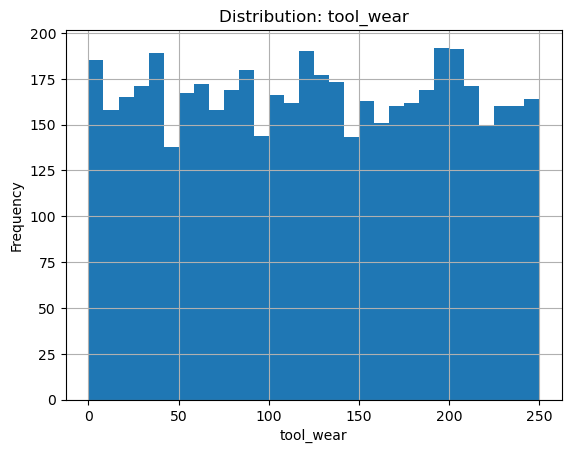

In [7]:
# Feature distributions
features = ['air_temperature','process_temperature','rotational_speed','torque','tool_wear']
for col in features:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## 4) Train/Test Split & Pipeline

In [9]:
X = df.drop('machine_failure', axis=1)
y = df['machine_failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

## 5) Evaluation

In [10]:
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       706
           1       0.80      0.78      0.79       544

    accuracy                           0.82      1250
   macro avg       0.82      0.82      0.82      1250
weighted avg       0.82      0.82      0.82      1250

ROC AUC: 0.9060065509915014


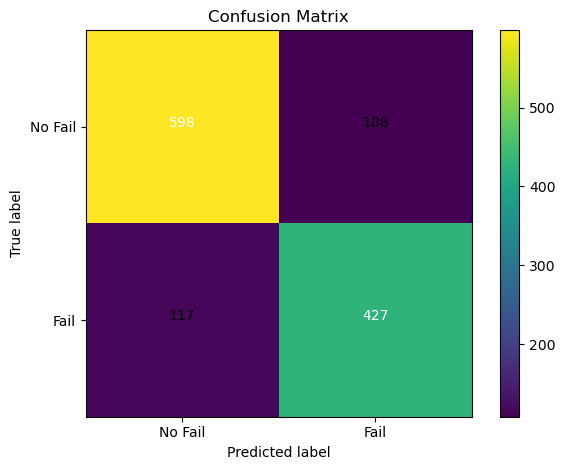

In [11]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Fail','Fail'])
plt.yticks(tick_marks, ['No Fail','Fail'])
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

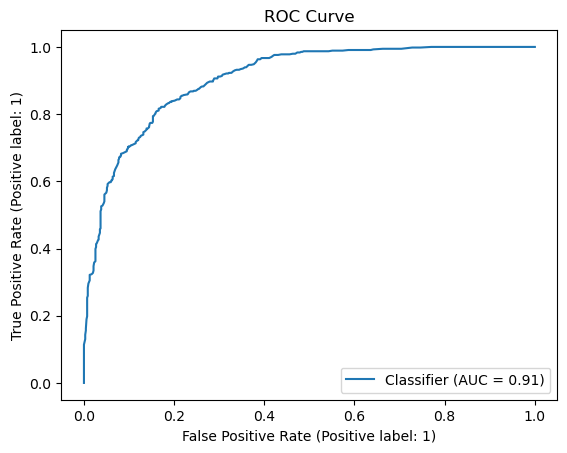

In [12]:
# ROC curve
fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title('ROC Curve')
plt.show()

## 6) Feature Importance

In [13]:
rf_model = pipe.named_steps['rf']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp

tool_wear              0.428088
rotational_speed       0.230232
torque                 0.135947
air_temperature        0.102886
process_temperature    0.102847
dtype: float64

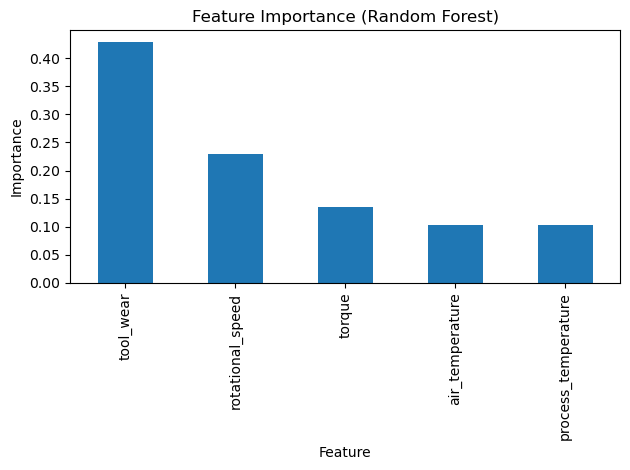

In [14]:
plt.figure()
feat_imp.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

## 7) Save Model for Frontend

In [16]:
models_dir = r'/Users/ajp/pm-ai-env'
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, 'predictive_maintenance_model.pkl')
joblib.dump(pipe, model_path)
model_path

'/Users/ajp/pm-ai-env/predictive_maintenance_model.pkl'

## 8) Inference Helper
Use this function to score new sensor readings.

In [17]:
import numpy as np
import joblib
loaded = joblib.load(model_path)

def predict_failure(air_temperature, process_temperature, rotational_speed, torque, tool_wear):
    X_new = pd.DataFrame([{
        'air_temperature': air_temperature,
        'process_temperature': process_temperature,
        'rotational_speed': rotational_speed,
        'torque': torque,
        'tool_wear': tool_wear
    }])
    prob = loaded.predict_proba(X_new)[:,1][0]
    pred = int(prob >= 0.5)
    return pred, float(prob)

predict_failure(300, 312, 1500, 40, 120)

(0, 0.23666666666666666)